<a href="https://colab.research.google.com/github/Bipinoli/AI_Adventure/blob/master/Pytorch_training_a_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

#Experimentation

In [56]:
a = torch.zeros(1, 4)
b = torch.zeros(1, 4)
b[0, 1] = 100
print(a, b)
print(a == b)

a = torch.zeros(2, 4)
b = torch.zeros(2, 4)
b[0, 1] = 100
a[1, 1] = 100
print(a, b)
print(a == b)
print((a == b).sum(dim = 0))
print((a == b).sum(dim = 1))
print((a == b).sum().item())

tensor([[0., 0., 0., 0.]]) tensor([[  0., 100.,   0.,   0.]])
tensor([[1, 0, 1, 1]], dtype=torch.uint8)
tensor([[  0.,   0.,   0.,   0.],
        [  0., 100.,   0.,   0.]]) tensor([[  0., 100.,   0.,   0.],
        [  0.,   0.,   0.,   0.]])
tensor([[1, 0, 1, 1],
        [1, 0, 1, 1]], dtype=torch.uint8)
tensor([2, 0, 2, 2])
tensor([3, 3])
6


#Data prepration

In [2]:
transform = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(), 
             torchvision.transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, num_workers=2, shuffle=True, drop_last=True)
x = next(iter(trainloader))
print(len(x))
print(x[0].shape, x[1].shape)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
type(classes)

Files already downloaded and verified
2
torch.Size([4, 3, 32, 32]) torch.Size([4])
Files already downloaded and verified


tuple

##visualization

torch.Size([32, 32])


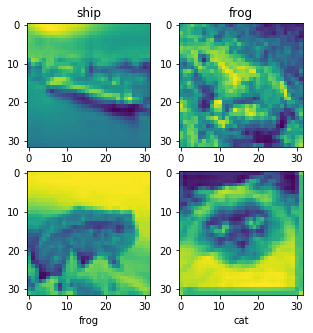

In [5]:
x = next(iter(trainloader))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5,5))
print(x[0][0][0].shape)
axes[0, 0].imshow(x[0][0][0])
axes[0, 0].set_title(classes[x[1][0]])
axes[0, 1].imshow(x[0][1][0])
axes[0, 1].set_title(classes[x[1][1]])
axes[1, 0].imshow(x[0][2][0])
axes[1, 0].set_xlabel(classes[x[1][2]])
axes[1, 1].imshow(x[0][3][0])
axes[1, 1].set_xlabel(classes[x[1][3]])
plt.show()

#CNN Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [4]:
net = CNN()
print(net)

# number of learable parameters in a model
learnable_params = 0
for name, param in net.named_parameters():
  if param.requires_grad:
    learnable_params += 1
    print(name)
    
print(learnable_params)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
10


##Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##Training

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("available gpus: ", torch.cuda.device_count())

if torch.cuda.device_count() > 1:
  print("let's use ", torch.cuda.device_count(), " GPUs!!")
  net = nn.DataParallel(net)
else:
  net.to(device)

print(device)

available gpus:  1
cuda:0


In [14]:
for epoch in range(2):
  
  running_loss = 0.0
  
  for i, data in enumerate(trainloader, start=0):
    inputs, labels = data[0].to(device), data[1].to(device)
    
    optimizer.zero_grad()
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
      running_loss = 0.0
      
print("Finished training")

[1,  2000] loss: 1.226
[1,  4000] loss: 1.251
[1,  6000] loss: 1.228
[1,  8000] loss: 1.220
[1, 10000] loss: 1.215
[1, 12000] loss: 1.197
[2,  2000] loss: 1.150
[2,  4000] loss: 1.139
[2,  6000] loss: 1.135
[2,  8000] loss: 1.137
[2, 10000] loss: 1.145
[2, 12000] loss: 1.121
Finished training


#Testing

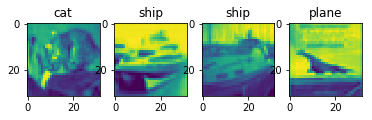

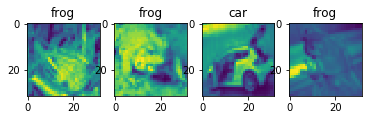

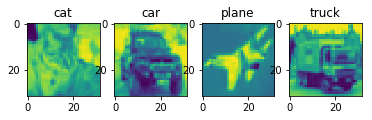

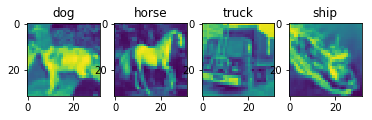

In [48]:
dataiter = iter(testloader)

images_list, labels_list = [], []

for _ in range(4):
  images, labels = dataiter.next()
  images_list.append(images)
  labels_list.append(labels)

  fig, axes = plt.subplots(nrows=1, ncols=4)
  for i in range(4):
    axes[i].set_title(classes[labels[i]])
    axes[i].imshow(images[i][0])
  plt.show()

  



In [49]:
for i in range(len(images_list)):
  outputs = net(images_list[i])
  _, max_indices = torch.max(outputs, dim=1)
  for i in max_indices:
    print(classes[i], end=" ")
  print("")

cat ship ship plane 
frog frog car frog 
cat car plane truck 
cat horse truck ship 


In [57]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    total += images.shape[0]
    outputs = net(images)
    _, predicted = torch.max(outputs, dim=1)
    correct += (predicted == labels).sum().item()
    
print("Accuracy of the network: %d %%" % (correct / total * 100))

Accuracy of the network: 54 %


##what classes were better classified?

In [59]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, dim=1)
    
    for i in range(images.shape[0]): # batch size
      class_total[labels[i]] += 1
      if labels[i] == predicted[i]:
        class_correct[labels[i]] += 1
        
for i in range(10):
  print("Accuracy of %5s : %2d %%" % (classes[i], class_correct[i]/class_total[i] * 100))
  

Accuracy of plane : 77 %
Accuracy of   car : 64 %
Accuracy of  bird : 29 %
Accuracy of   cat : 49 %
Accuracy of  deer : 55 %
Accuracy of   dog : 18 %
Accuracy of  frog : 70 %
Accuracy of horse : 68 %
Accuracy of  ship : 66 %
Accuracy of truck : 51 %
